In [ ]:
import random

import matplotlib.pyplot as plt
from google.colab import drive
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import numpy as np


seed_value = 44
torch.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)
np.random.seed(seed_value)

drive.mount('/gdrive')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Mounted at /gdrive


In [ ]:
d_loss_file = "/gdrive/MyDrive/Magisterka/final_gan_model/results/D_losses_values.txt"
with open(d_loss_file, 'r') as file:
    D_losses = [float(line.strip()) for line in file]

g_loss_file = "/gdrive/MyDrive/Magisterka/final_gan_model/results/G_losses_values.txt"
with open(g_loss_file, 'r') as file:
    G_losses = [float(line.strip()) for line in file]

fid_file = "/gdrive/MyDrive/Magisterka/final_gan_model/results/FID_values.txt"
with open(fid_file, 'r') as file:
    FID_values = [float(line.strip()) for line in file]

is_file = "/gdrive/MyDrive/Magisterka/final_gan_model/results/IS_values.txt"
with open(is_file, 'r') as file:
    IS_values = [float(line.strip()) for line in file]

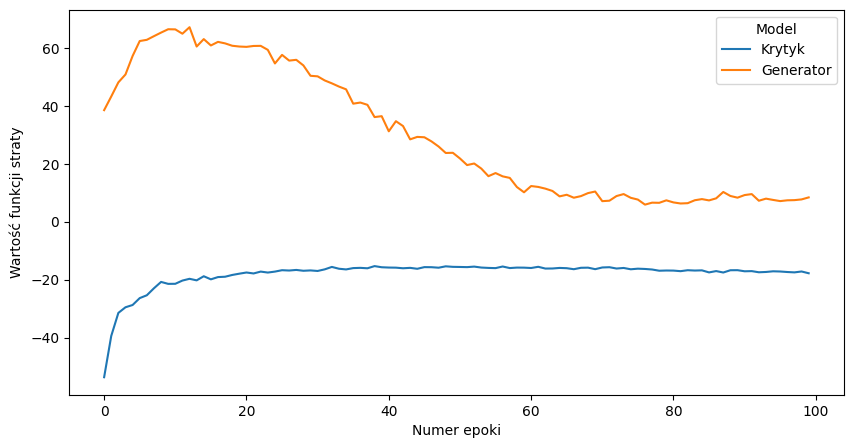

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(D_losses,label="Krytyk")
plt.plot(G_losses,label="Generator")
plt.xlabel("Numer epoki")
plt.ylabel("Wartość funkcji straty")
plt.legend(title="Model")
plt.savefig('loss.eps', format='eps', dpi=1200)
plt.show()

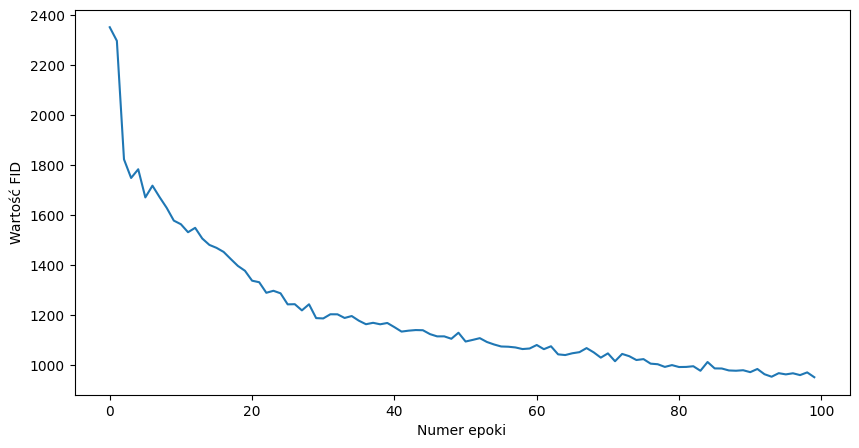

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(FID_values)
plt.xlabel("Numer epoki")
plt.ylabel("Wartość FID")
plt.savefig('fid.eps', format='eps', dpi=1200)
plt.show()

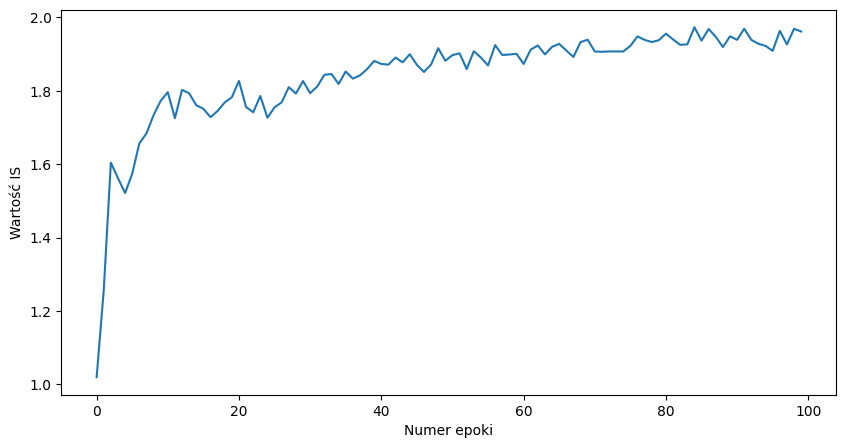

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(IS_values)
plt.xlabel("Numer epoki")
plt.ylabel("Wartość IS")
plt.savefig('is.eps', format='eps', dpi=1200)
plt.show()

In [ ]:
class Generator(nn.Module):
    def __init__(self, channels_noise, channels_img, features_g, num_classes,
                 img_size, embed_size):
        super(Generator, self).__init__()
        self.img_size = img_size
        self.net = nn.Sequential(
            self._block(channels_noise + embed_size, features_g * 32, 4, 1, 0),
            self._block(features_g * 32, features_g * 16, 4, 2, 1),
            self._block(features_g * 16, features_g * 8, 4, 2, 1),
            self._block(features_g * 8, features_g * 4, 4, 2, 1),
            self._block(features_g * 4, features_g * 2, 4, 2, 1),
            nn.ConvTranspose2d(
                features_g * 2, channels_img, kernel_size=4, stride=2, padding=1
            ),
            nn.Tanh(),
        )
        self.embed = nn.Embedding(num_classes, embed_size)

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x, labels):
        embedding = self.embed(labels).unsqueeze(2).unsqueeze(3)
        x = torch.cat([x, embedding], dim=1)
        return self.net(x)

IMAGE_SIZE = 128
CHANNELS_IMG = 1
NUM_CLASSES = 2
GEN_EMBEDDING = 100
NOISE_DIM = 100
FEATURES_GEN = 128

In [ ]:
loaded_gen = Generator(NOISE_DIM, CHANNELS_IMG, FEATURES_GEN, NUM_CLASSES, IMAGE_SIZE, GEN_EMBEDDING).to(device)
loaded_gen.load_state_dict(torch.load('/gdrive/MyDrive/Magisterka/final_gan_model/generator_model.pth'))
loaded_gen.eval()

Generator(
  (net): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(200, 4096, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): BatchNorm2d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): ConvTranspose2d(4096, 2048, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (2): Sequential(
      (0): ConvTranspose2d(2048, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (3): Sequential(
      (0): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (4): Sequential(
      

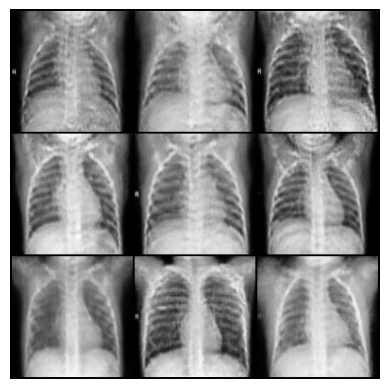

In [ ]:
with torch.no_grad():
    sample_noise = torch.randn(9, NOISE_DIM, 1, 1).to(device)
    labels = torch.tensor(9*[0]).to(device)
    generated_images = loaded_gen(sample_noise, labels)

    img_grid = torchvision.utils.make_grid(generated_images, normalize=True, nrow=3)
    plt.imshow(img_grid.permute(1, 2, 0).cpu().numpy())
    plt.axis('off')
    plt.savefig('generated_normal_3x3.png', dpi=1200)
    plt.show()

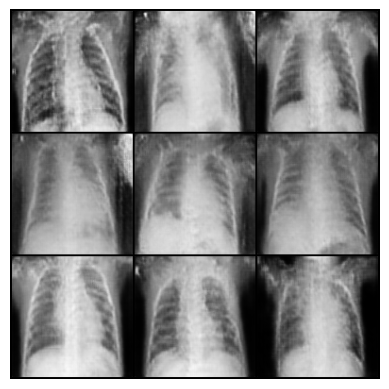

In [ ]:
with torch.no_grad():
    sample_noise = torch.randn(9, NOISE_DIM, 1, 1).to(device)
    labels = torch.tensor(9*[1]).to(device)
    generated_images = loaded_gen(sample_noise, labels)

    img_grid = torchvision.utils.make_grid(generated_images, normalize=True, nrow=3)
    plt.imshow(img_grid.permute(1, 2, 0).cpu().numpy())
    plt.axis('off')
    plt.savefig('generated_pneumonia_3x3.png', dpi=1200)
    plt.show()